# Rai Price Correlation - As of 3-24-2021

In this notebook, we read in the data that was generated and saved as a csv from the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and examined if there is a relationship between Rai and Eth price moves.


## Correlation of RAI to Eth price moves 

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univaraite autoregression models allowing for multiivate rimme series.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$


For our VAR model, we will have a vector of prices, $P$ of EthRai(marketPriceEth),RaiUSD(marketPriceUsd), and EthUSD price moves.


#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differenceing can be used to make the data stationary.
* Data is on the same scale


In [378]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from math import sqrt

## Import data and preprocess

In [379]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [380]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,redemptionPrice,redemptionRate,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,...,currentCoinMedianizerUpdate,debtAvailableToSettle,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice
0,11857308,1988.440433,1988.577499,"{'block': '11849022', 'id': '0xe313271188492c4...",{'hourlyRate': '1'},1613338681,3.14,3.14,0.002589,4.670500,...,NaN,0.0,115792089237316195423570985008687.9,0.068533,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14
1,11860793,2788.440433,2788.617717,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",{'hourlyRate': '1'},1613384616,3.14,3.14,0.002481,4.377049,...,NaN,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14
2,11861040,2788.440433,2788.657935,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",{'hourlyRate': '1'},1613387890,3.14,3.14,0.002481,4.406833,...,NaN,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14
3,11861337,2788.440433,2788.657935,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613392101,3.14,3.14,0.002481,4.419266,...,NaN,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14
4,11861474,3048.440433,3048.645955,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613394096,3.14,3.14,0.001769,3.194330,...,{'value': '0'},0.0,115792089237316195423570985008687.9,0.116162,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14


## Exploratory Analysis

In [381]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,totalAnnualizedStabilityFee,totalCollateral,Eth_price,debtAvailableToSettle,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice
count,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,878.000000,878.000000,878.000000,878.000000,878.000000,8.780000e+02,...,8.780000e+02,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,1.198084e+07,3.354361e+07,3.398548e+07,1.614981e+09,3.064162,3.064162,0.001878,3.209433,0.029613,4.358864e+07,...,1.020000e+00,154027.885417,1723.570051,318029.134305,105646.268431,791.764237,0.775977,0.999957,0.999659,3.064160
std,6.974728e+04,1.408364e+07,1.420170e+07,9.280062e+05,0.049037,0.049037,0.000296,0.440628,0.227098,1.583802e+07,...,1.177507e-14,64173.007883,153.174336,373639.756212,67112.508839,270.554509,0.342958,0.000060,0.000477,0.049035
min,1.185731e+07,1.988440e+03,1.988577e+03,1.613339e+09,3.013686,3.013686,0.001600,2.850455,0.000000,1.000000e+07,...,1.020000e+00,14.892360,1328.192602,0.000000,-8000.336813,3.000000,0.168066,0.999796,0.998373,3.013686
25%,1.192067e+07,2.893896e+07,2.923238e+07,1.614181e+09,3.017978,3.017978,0.001671,3.002190,0.000000,3.463856e+07,...,1.020000e+00,131670.549349,1594.927574,16621.371185,37470.675306,781.000000,0.492754,0.999919,0.999354,3.017978
50%,1.198031e+07,3.492160e+07,3.563961e+07,1.614974e+09,3.043398,3.043398,0.001772,3.132480,0.000000,4.686430e+07,...,1.020000e+00,177923.241509,1772.375961,45752.103558,144529.881573,836.000000,0.735939,0.999965,0.999720,3.043398
75%,1.204066e+07,4.484609e+07,4.506986e+07,1.615778e+09,3.113550,3.113550,0.002049,3.262714,0.000000,5.727986e+07,...,1.020000e+00,198583.779035,1822.945099,702270.918150,155161.503311,1004.000000,1.050516,1.000006,1.000045,3.113397
max,1.210370e+07,4.899876e+07,4.918825e+07,1.616617e+09,3.140000,3.140000,0.004474,8.055382,3.000000,5.727986e+07,...,1.020000e+00,209393.009759,2032.578356,943944.359793,173668.010370,1021.000000,1.475756,1.000044,1.000355,3.140000


In [382]:
graphData.columns

Index(['blockNumber', 'erc20CoinTotalSupply', 'globalDebt', 'redemptionPrice',
       'redemptionRate', 'timestamp', 'hourlyredemptionPriceActual',
       'hourlyredemptionRateActual', 'hourlymarketPriceEth',
       'hourlymarketPriceUsd', 'activeLiquidations', 'currentFsmUpdate',
       'currentMedianizerUpdate', 'debtCeiling', 'liquidationsStarted',
       'totalAnnualizedStabilityFee', 'totalCollateral', 'Eth_price',
       'coinAddress', 'coinUniswapPair', 'currentCoinMedianizerUpdate',
       'debtAvailableToSettle', 'globalDebtCeiling', 'systemSurplus',
       'totalActiveSafeCount', 'wethAddress', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice'],
      dtype='object')

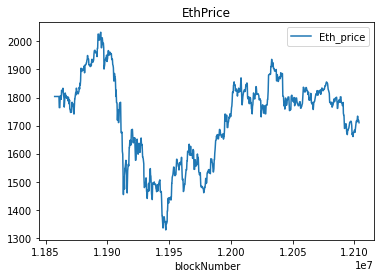

In [383]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

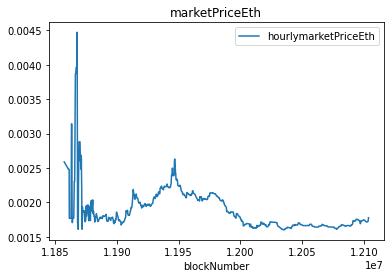

In [384]:
graphData.plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceEth')

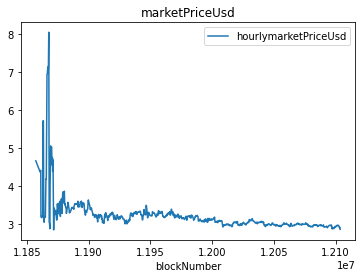

In [385]:
graphData.plot(x='blockNumber',y='hourlymarketPriceUsd',kind='line',title='marketPriceUsd')

In [386]:
# subset data to vector for VAR
P = graphData[['hourlymarketPriceEth','hourlymarketPriceUsd','Eth_price']]


In [387]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price
count,878.000000,878.000000,878.000000
mean,0.001878,3.209433,1723.570051
std,0.000296,0.440628,153.174336
min,0.001600,2.850455,1328.192602
25%,0.001671,3.002190,1594.927574
50%,0.001772,3.132480,1772.375961
75%,0.002049,3.262714,1822.945099
max,0.004474,8.055382,2032.578356


In [388]:
## Difference and log values
P['marketPriceEth_log_differenced'] = np.log(P['hourlymarketPriceEth']).diff()
P['marketPriceUsd_log_differenced'] = np.log(P['hourlymarketPriceUsd']).diff()
P['Eth_price_log_differenced'] = np.log(P['Eth_price']).diff()

<ipython-input-388-1523501b345d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceEth_log_differenced'] = np.log(P['hourlymarketPriceEth']).diff()
<ipython-input-388-1523501b345d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceUsd_log_differenced'] = np.log(P['hourlymarketPriceUsd']).diff()
<ipython-input-388-1523501b345d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

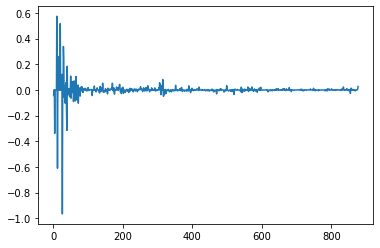

In [389]:
P.marketPriceEth_log_differenced.plot()

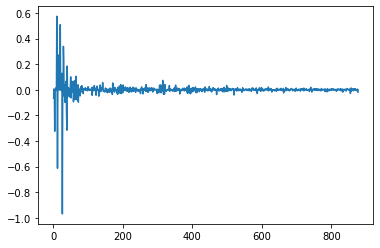

In [390]:
P.marketPriceUsd_log_differenced.plot()

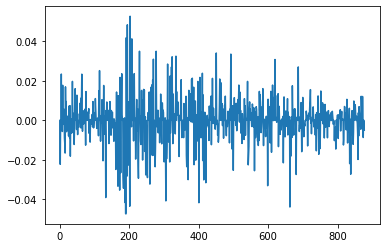

In [391]:
P.Eth_price_log_differenced.plot()

In [392]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced
count,878.000000,878.000000,878.000000,877.000000,877.000000,877.000000
mean,0.001878,3.209433,1723.570051,-0.000429,-0.000558,-0.000061
std,0.000296,0.440628,153.174336,0.054819,0.055166,0.010845
min,0.001600,2.850455,1328.192602,-0.966119,-0.970155,-0.047327
25%,0.001671,3.002190,1594.927574,-0.002728,-0.004990,-0.003006
50%,0.001772,3.132480,1772.375961,-0.000051,-0.000005,0.000000
75%,0.002049,3.262714,1822.945099,0.001536,0.004712,0.003756
max,0.004474,8.055382,2032.578356,0.574561,0.574204,0.052679


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [393]:
# scaler objects
scalers = []
# features to scale
features = ['marketPriceEth_log_differenced','marketPriceUsd_log_differenced','Eth_price_log_differenced']
for i in features:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers.append(scaler)
    string = i + '_standardized'
    P[string] = scaler.transform(values)

Mean: -0.000429, StandardDeviation: 0.054787
Mean: -0.000558, StandardDeviation: 0.055135
Mean: -0.000061, StandardDeviation: 0.010839


<ipython-input-393-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P[string] = scaler.transform(values)
<ipython-input-393-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P[string] = scaler.transform(values)
<ipython-input-393-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [394]:
P.describe()

,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced,marketPriceEth_log_differenced_standardized,marketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized
count,878.000000,878.000000,878.000000,877.000000,877.000000,877.000000,8.770000e+02,8.770000e+02,8.770000e+02
mean,0.001878,3.209433,1723.570051,-0.000429,-0.000558,-0.000061,-5.190324e-18,1.962196e-18,-1.481141e-17
std,0.000296,0.440628,153.174336,0.054819,0.055166,0.010845,1.000571e+00,1.000571e+00,1.000571e+00
min,0.001600,2.850455,1328.192602,-0.966119,-0.970155,-0.047327,-1.762610e+01,-1.758596e+01,-4.360812e+00
25%,0.001671,3.002190,1594.927574,-0.002728,-0.004990,-0.003006,-4.197086e-02,-8.038650e-02,-2.717777e-01
50%,0.001772,3.132480,1772.375961,-0.000051,-0.000005,0.000000,6.901272e-03,1.003086e-02,5.599708e-03
75%,0.002049,3.262714,1822.945099,0.001536,0.004712,0.003756,3.586510e-02,9.557272e-02,3.521434e-01
max,0.004474,8.055382,2032.578356,0.574561,0.574204,0.052679,1.049491e+01,1.042467e+01,4.865778e+00


In [395]:
P.fillna(0,inplace=True)

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Fit model

In [396]:
# instantiate the var model object from statsmodels
model = VAR(P[['marketPriceEth_log_differenced_standardized',
               'marketPriceUsd_log_differenced_standardized',
               'Eth_price_log_differenced_standardized']])

In [397]:
# calculate the best autocorrelation value
results = model.fit(maxlags=10, ic='aic')

In [398]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Mar, 2021
Time:                     16:46:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.80855
Nobs:                     869.000    HQIC:                  -4.09304
Log likelihood:          -1760.13    FPE:                  0.0139915
AIC:                     -4.26937    Det(Omega_mle):       0.0127217
--------------------------------------------------------------------
Results for equation marketPriceEth_log_differenced_standardized
                                                    coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------
const                                                  0.015315         0.029776            0.514           0.607
L1.m

The Akaike information criterion(AIC) is used to evaluate how well a model fits the data. It penalizes for more independent variables to try to prevent over-fitting. AIC is calculated by the maximum log-likelihood of the model and the number of parameters (K) used to reach that likelihood. The AIC function is 2K – 2(log-likelihood).

Lower AIC values indicate a better-fit model, and a model with a delta-AIC (the difference between the two AIC values being compared) of more than -2 is considered significantly better than the model it is being compared to.

- https://www.scribbr.com/statistics/akaike-information-criterion/

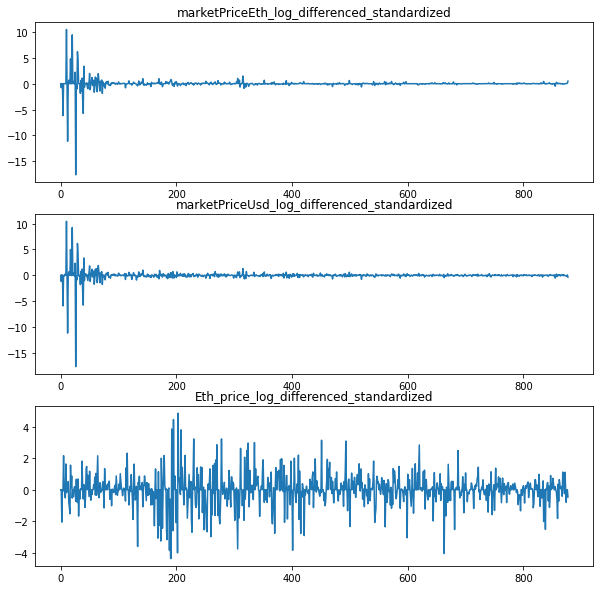

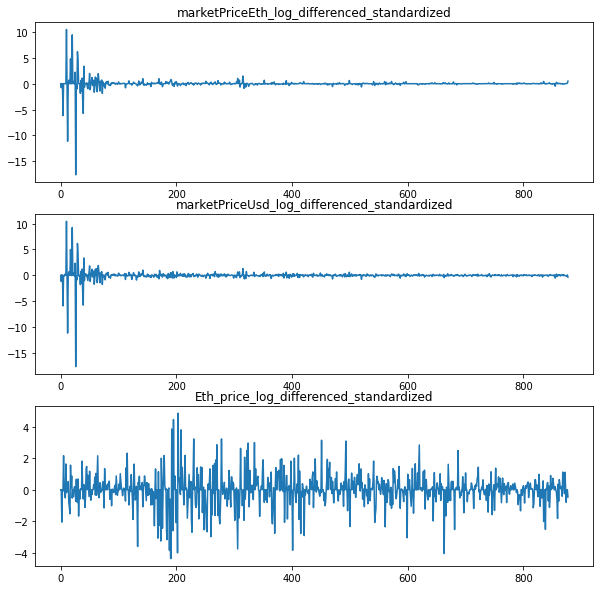

In [399]:
results.plot()

In [400]:
# plot the autocorrelation function
#results.plot_acorr()

## Impulse Response Analysis

Impulse response is used in econometrics and macroeconomic modeling to study how the system reacts to exogenous shocks. In signal processing, an impulse response is the reaction of a dynamic system in response to some external change. The Impulse response below is the estimated responses of a variable to a unit impulse.

In [401]:
# 50 periods
irf = results.irf(50)

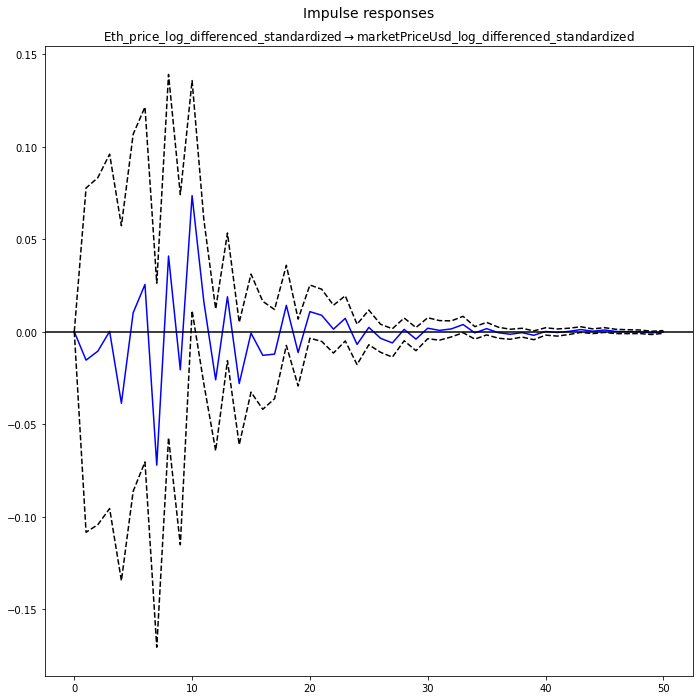

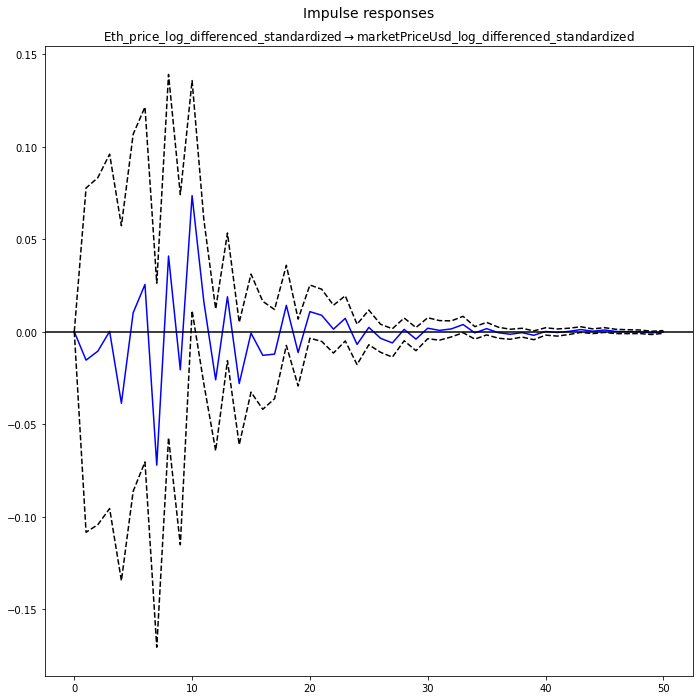

In [402]:
irf.plot(impulse='Eth_price_log_differenced_standardized', #variable providing the impulse
         response='marketPriceUsd_log_differenced_standardized', # variable affected by the impulse
         plot_stderr = True, #Plot standard impulse response error bands
        repl=1000) #Number of replications for Monte Carlo and Sims-Zha standard errors

Standard errors are plotted by default at the 95% significance level.

### Granger causality

Test to see if eth price is has any casual component for the Rai market price.

In [403]:
results.test_causality(['marketPriceEth_log_differenced_standardized', 
                        'marketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f').summary()

Test statistic,Critical value,p-value,df
1.398,1.608,0.122,"(18, 2523)"


Based on the Granger Causality test, Eth_price_log_differenced_standardized does have a casually influence Rai price.

## Normality
The white noise component is assumed to be normally distributed. Results are more reliable when this assumption is met. We will test it below using the Jarque-Bera-test for normality.

In [404]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
2.699e+05,12.59,0.000,6


The results were not normal, which reduces the reliability of our assumptions. However, if this analysis was run after the initial price movements, the results would most likely be normal.

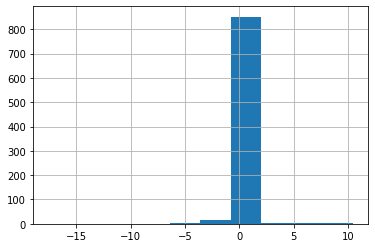

In [405]:
P.marketPriceUsd_log_differenced_standardized.hist()

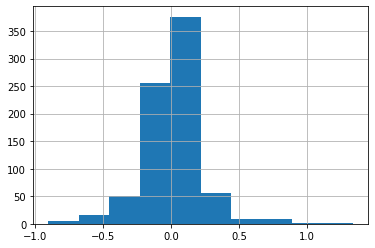

In [406]:
P.marketPriceUsd_log_differenced_standardized[100:].hist()

As you can see, if we skipped the first 100 data points, the data appears a lot more normal

## Correlation Analysis

,marketPriceEth_log_differenced_standardized,marketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized
marketPriceEth_log_differenced_standardized,1.000000,0.978891,-0.012661
marketPriceUsd_log_differenced_standardized,0.978891,1.000000,0.000142
Eth_price_log_differenced_standardized,-0.012661,0.000142,1.000000


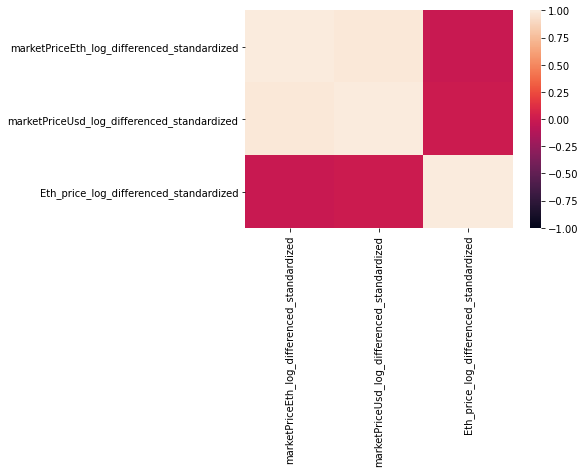

In [407]:
corr = P[['marketPriceEth_log_differenced_standardized',
          'marketPriceUsd_log_differenced_standardized',
          'Eth_price_log_differenced_standardized']].corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

Using Pearson's correlation, we have a -0.012661.

## Conclusion

Based on our VAR analysis, Eth price does have an influence on the Rai price.